# Assignment 2 - Semi-gradient TD with a Neural Network

Welcome to Course 3 Programming Assignment 2. In the previous assignment, you implemented semi-gradient TD with State Aggregation for solving a **policy evaluation task**. In this assignment, you will implement **semi-gradient TD with a simple Neural Network** and use it for the same policy evaluation problem. 

You will implement an agent to evaluate a fixed policy on the 500-State Randomwalk. As you may remember from the previous assignment, the 500-state Randomwalk includes 500 states. Each episode begins with the agent at the center and terminates when the agent goes far left beyond state 1 or far right beyond state 500. At each time step, the agent selects to move either left or right with equal probability. The environment determines how much the agent moves in the selected direction.

**In this assignment, you will:**
- Implement stochastic gradient descent method for state-value prediction.
- Implement semi-gradient TD with a neural network as the function approximator and Adam algorithm.
- Compare performance of semi-gradient TD with a neural network and semi-gradient TD with tile-coding.


## Packages
We import the following libraries that are required for this assignment:

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [RL-Glue](http://www.jmlr.org/papers/v10/tanner09a.html) : Library for reinforcement learning experiments.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments.
- BaseOptimizer : An abstract class that specifies the optimizer API for Agent.
- plot_script : Custom script to plot results.
- RandomWalkEnvironment : The Randomwalk environment script from Course 3 Assignment 1.

In [1]:
# Do not modify this cell!

# Import necessary libraries
# DO NOT IMPORT OTHER LIBRARIES - This will break the autograder.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
from optimizer import BaseOptimizer
import plot_script
from randomwalk_environment import RandomWalkEnvironment

## Section 1: Create semi-gradient TD with a Neural Network
In this section, you will implement an Agent that learns with semi-gradient TD with a neural network. You will use a neural network with one hidden layer. The input of the neural network is the one-hot encoding of the state number. We use the one-hot encoding of the state number instead of the state number itself because we do not want to build the prior knowledge that integer number inputs close to each other have similar values. The hidden layer contains 100 rectifier linear units (ReLUs) which pass their input if it is bigger than one and return 0 otherwise. ReLU gates are commonly used in neural networks due to their nice properties such as the sparsity of the activation and having non-vanishing gradients. The output of the neural network is the estimated state value. It is a linear function of the hidden units as is commonly the case when estimating the value of a continuous target using neural networks.

The neural network looks like this:
![](nn_structure.png)


For a given input, $s$, value of $s$ is computed by:
$$
\begin{align} 
\psi &= sW^{[0]} + b^{[0]} \\
x &= \textit{max}(0, \psi) \\
v &= xW^{[1]} + b^{[1]}
\end{align} 
$$

where $W^{[0]}$, $b^{[0]}$, $W^{[1]}$, $b^{[1]}$  are the parameters of the network and will be learned when training the agent.

## 1-1: Implement helper methods

Before implementing the agent, you first implement some helper functions which you will later use in agent's main methods. 

### Implement `get_value()`
First, you will implement get_value() method which feeds an input $s$ into the neural network and returns the output of the network $v$ according to the equations above. To implement get_value(), take into account the following notes:

- `get_value()` gets the one-hot encoded state number denoted by s as an input. 
- `get_value()` receives the weights of the neural network as input, denoted by weights and structured as an array of dictionaries. Each dictionary corresponds to weights from one layer of the neural network to the next. Each dictionary includes $W$ and $b$. The shape of the elements in weights are as follows:
    - weights[0]["W"]: num_states $\times$ num_hidden_units
    - weights[0]["b"]: 1 $\times$ num_hidden_units
    - weights[1]["W"]: num_hidden_units $\times$ 1
    - weights[1]["b"]: 1 $\times$ 1

- The input of the neural network is a sparse vector. To make computation faster, we take advantage of input sparsity. To do so, we provided a helper method `my_matmul()`. **Make sure that you use `my_matmul()` for all matrix multiplications except for element-wise multiplications in this notebook.**
- The max operator used for computing $x$ is element-wise. 

In [2]:
def my_matmul(x1, x2):
    """
    Given matrices x1 and x2, return the multiplication of them
    """
    
    result = np.zeros((x1.shape[0], x2.shape[1]))
    x1_non_zero_indices = x1.nonzero()
    if x1.shape[0] == 1 and len(x1_non_zero_indices[1]) == 1:
        result = x2[x1_non_zero_indices[1], :]
    elif x1.shape[1] == 1 and len(x1_non_zero_indices[0]) == 1:
        result[x1_non_zero_indices[0], :] = x2 * x1[x1_non_zero_indices[0], 0]
    else:
        result = np.matmul(x1, x2)
    return result

In [4]:
# -----------
# Graded Cell
# -----------

def get_value(s, weights):
    """
    Compute value of input s given the weights of a neural network
    """
    ### Compute the ouput of the neural network, v, for input s
    
    # ----------------
    # your code here
    W0 = weights[0]['W']
    b0 = weights[0]['b']
    W1 = weights[1]['W']
    b1 = weights[1]['b']
    
    psi = my_matmul(s, W0) + b0
    x = np.where(psi > 0, psi, 0)
    v = my_matmul(x, W1) + b1
    # ----------------
    return v

Run the following code to test your implementation of the `get_value()` function:

In [5]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# Suppose num_states = 5, num_hidden_layer = 1, and num_hidden_units = 10 
num_hidden_layer = 1
s = np.array([[0, 0, 0, 1, 0]])

weights_data = np.load("asserts/get_value_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

estimated_value = get_value(s, weights)
print ("Estimated value: {}".format(estimated_value))

assert(np.allclose(estimated_value, [[-0.21915705]]))

Estimated value: [[-0.21915705]]


**Expected output**:

    Estimated value: [[-0.21915705]]

### Implement `get_gradient()`
You will also implement `get_gradient()` method which computes the gradient of the value function for a given input, using backpropagation. You will later use this function to update the value function. 

As you know, we compute the value of a state $s$ according to: 
$$
\begin{align} 
\psi &= sW^{[0]} + b^{[0]} \\
x &= \textit{max}(0, \psi) \\
v &= xW^{[1]} + b^{[1]}
\end{align} 
$$

To update the weights of the neural network ($W^{[0]}$, $b^{[0]}$, $W^{[1]}$, $b^{[1]}$), we compute the gradient of $v$ with respect to the weights according to:

$$
\begin{align} 
\frac{\partial v}{\partial W^{[0]}} &= s^T(W^{[1]T} \odot I_{x>0}) \\
\frac{\partial v}{\partial b^{[0]}} &= W^{[1]T} \odot I_{x>0} \\
\frac{\partial v}{\partial W^{[1]}} &= x^T \\
\frac{\partial v}{\partial b^{[1]}} &= 1
\end{align}
$$
where $\odot$ denotes element-wise matrix multiplication and $I_{x>0}$ is the gradient of the ReLU activation function which is an indicator whose $i$th element is 1 if $x[i]>0$ and 0 otherwise.

In [6]:
# -----------
# Graded Cell
# -----------

def get_gradient(s, weights):
    """
    Given inputs s and weights, return the gradient of v with respect to the weights
    """

    ### Compute the gradient of the value function with respect to W0, b0, W1, b1 for input s
    # grads[0]["W"] = ?
    # grads[0]["b"] = ?
    # grads[1]["W"] = ?
    # grads[1]["b"] = ?
    # Note that grads[0]["W"], grads[0]["b"], grads[1]["W"], and grads[1]["b"] should have the same shape as 
    # weights[0]["W"], weights[0]["b"], weights[1]["W"], and weights[1]["b"] respectively
    # Note that to compute the gradients, you need to compute the activation of the hidden layer (x)

    grads = [dict() for i in range(len(weights))]

    # ----------------
    # your code here
    W0 = weights[0]['W']
    b0 = weights[0]['b']
    W1 = weights[1]['W']
    b1 = weights[1]['b']
    
    psi = my_matmul(s, W0) + b0
    x = np.where(psi > 0, psi, 0)
    I = np.where(x>0, 1, 0)
    
    grads[0]["W"] = my_matmul(s.T,(np.multiply(W1.T, I)))
    grads[0]["b"] = np.multiply(W1.T, I)
    grads[1]["W"] = x.T
    grads[1]["b"] = 1
    # ----------------

    return grads


Run the following code to test your implementation of the `get_gradient()` function:

In [7]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# Suppose num_states = 5, num_hidden_layer = 1, and num_hidden_units = 2 
num_hidden_layer = 1
s = np.array([[0, 0, 0, 1, 0]])

weights_data = np.load("asserts/get_gradient_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

grads = get_gradient(s, weights)

grads_answer = np.load("asserts/get_gradient_grads.npz")

assert(np.allclose(grads[0]["W"], grads_answer["W0"]))
assert(np.allclose(grads[0]["b"], grads_answer["b0"]))
assert(np.allclose(grads[1]["W"], grads_answer["W1"]))
assert(np.allclose(grads[1]["b"], grads_answer["b1"]))

**Expected output**:

    grads[0]["W"]
     [[0.         0.        ]
     [0.         0.        ]
     [0.         0.        ]
     [0.76103773 0.12167502]
     [0.         0.        ]] 

    grads[0]["b"]
     [[0.76103773 0.12167502]] 

    grads[1]["W"]
     [[0.69198983]
     [0.82403662]] 

    grads[1]["b"]
     [[1.]] 

### Implement stochastic gradient descent method for state-value prediction
In this section, you will implement stochastic gradient descent (SGD) method for state_value prediction. Here is the basic SGD update for state-value prediction with TD:

$$\mathbf{w_{t+1}} = \mathbf{w_{t}} + \alpha \delta_t \nabla \hat{v}(S_t,\mathbf{w_{t}})$$

At each time step, we update the weights in the direction  $g_t = \delta_t \nabla \hat{v}(S_t,\mathbf{w_t})$ using a fixed step-size $\alpha$. $\delta_t = R_{t+1} + \gamma \hat{v}(S_{t+1},\mathbf{w_{t}}) - \hat{v}(S_t,\mathbf{w_t})$ is the TD-error. $\nabla \hat{v}(S_t,\mathbf{w_{t}})$ is the gradient of the value function with respect to the weights.

The following cell includes the SGD class. You will complete the `update_weight()` method of SGD assuming that the weights and update g are provided.

**As you know, in this assignment, we structured the weights as an array of dictionaries. Note that the updates $g_t$, in the case of TD, is $\delta_t \nabla \hat{v}(S_t,\mathbf{w_t})$. As a result, $g_t$ has the same structure as $\nabla \hat{v}(S_t,\mathbf{w_t})$ which is also an array of dictionaries.**

In [8]:
# -----------
# Graded Cell
# -----------

class SGD(BaseOptimizer):
    def __init__(self):
        pass
    
    def optimizer_init(self, optimizer_info):
        """Setup for the optimizer.

        Set parameters needed to setup the stochastic gradient descent method.

        Assume optimizer_info dict contains:
        {
            step_size: float
        }
        """
        self.step_size = optimizer_info.get("step_size")
    
    def update_weights(self, weights, g):
        """
        Given weights and update g, return updated weights
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                
                ### update weights
                # weights[i][param] = None
                
                # ----------------
                # your code here
                weights[i][param] += self.step_size * g[i][param]
                # ----------------
                
        return weights

Run the following code to test your implementation of the `update_weights()` function:

In [10]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

# Suppose num_states = 5, num_hidden_layer = 1, and num_hidden_units = 2 
num_hidden_layer = 1

weights_data = np.load("asserts/update_weights_weights.npz")
weights = [dict() for i in range(num_hidden_layer+1)]
weights[0]["W"] = weights_data["W0"]
weights[0]["b"] = weights_data["b0"]
weights[1]["W"] = weights_data["W1"]
weights[1]["b"] = weights_data["b1"]

g_data = np.load("asserts/update_weights_g.npz")
g = [dict() for i in range(num_hidden_layer+1)]
g[0]["W"] = g_data["W0"]
g[0]["b"] = g_data["b0"]
g[1]["W"] = g_data["W1"]
g[1]["b"] = g_data["b1"]

test_sgd = SGD()
optimizer_info = {"step_size": 0.3}
test_sgd.optimizer_init(optimizer_info)
updated_weights = test_sgd.update_weights(weights, g)

# updated weights asserts
updated_weights_answer = np.load("asserts/update_weights_updated_weights.npz")

assert(np.allclose(updated_weights[0]["W"], updated_weights_answer["W0"]))
assert(np.allclose(updated_weights[0]["b"], updated_weights_answer["b0"]))
assert(np.allclose(updated_weights[1]["W"], updated_weights_answer["W1"]))
assert(np.allclose(updated_weights[1]["b"], updated_weights_answer["b1"]))

**Expected output**:

    updated_weights[0]["W"]
     [[ 1.17899492  0.53656321]
     [ 0.58008221  1.47666572]
     [ 1.01909411 -1.10248056]
     [ 0.72490408  0.06828853]
     [-0.20609725  0.69034095]] 

    updated_weights[0]["b"]
     [[-0.18484533  0.92844539]] 

    updated_weights[1]["W"]
     [[0.70488257]
     [0.58150878]] 

    updated_weights[1]["b"]
     [[0.88467086]] 

### Adam Algorithm
In this assignment, instead of using SGD for updating the weights, we use a more advanced algorithm called Adam. The Adam algorithm improves the SGD update with two concepts: adaptive vector step-sizes and momentum. It keeps estimates of the mean and second moment of the updates, denoted by $\mathbf{m}$ and $\mathbf{v}$ respectively:
$$\mathbf{m_t} = \beta_m \mathbf{m_{t-1}} + (1 - \beta_m)g_t \\
\mathbf{v_t} = \beta_v \mathbf{v_{t-1}} + (1 - \beta_v)g^2_t
$$

Given that $\mathbf{m}$ and $\mathbf{v}$ are initialized to zero, they are biased toward zero. To get unbiased estimates of the mean and second moment, Adam defines $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ as:
$$ \mathbf{\hat{m_t}} = \frac{\mathbf{m_t}}{1 - \beta_m^t} \\
\mathbf{\hat{v_t}} = \frac{\mathbf{v_t}}{1 - \beta_v^t}
$$

The weights are then updated as follows:
$$ \mathbf{w_t} = \mathbf{w_{t-1}} + \frac{\alpha}{\sqrt{\mathbf{\hat{v_t}}}+\epsilon} \mathbf{\hat{m_t}}
$$

When implementing the agent you will use the Adam algorithm instead of SGD because it is more efficient. We have already provided you the implementation of the Adam algorithm in the cell below. You will use it when implementing your agent. 

In [11]:
# ---------------
# Discussion Cell
# ---------------
class Adam(BaseOptimizer):
    def __init__(self):
        pass
    
    def optimizer_init(self, optimizer_info):
        """Setup for the optimizer.

        Set parameters needed to setup the Adam algorithm.

        Assume optimizer_info dict contains:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float, 
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
        }
        """
        
        self.num_states = optimizer_info.get("num_states")
        self.num_hidden_layer = optimizer_info.get("num_hidden_layer")
        self.num_hidden_units = optimizer_info.get("num_hidden_units")

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")

        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])

        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(self.num_hidden_layer+1)]
        self.v = [dict() for i in range(self.num_hidden_layer+1)]

        for i in range(self.num_hidden_layer+1):

            # Initialize self.m[i]["W"], self.m[i]["b"], self.v[i]["W"], self.v[i]["b"] to zero
            self.m[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.m[i]["b"] = np.zeros((1, self.layer_size[i+1]))
            self.v[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.v[i]["b"] = np.zeros((1, self.layer_size[i+1]))

        # Initialize beta_m_product and beta_v_product to be later used for computing m_hat and v_hat
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v

    def update_weights(self, weights, g):
        """
        Given weights and update g, return updated weights
        """
        
        for i in range(len(weights)):
            for param in weights[i].keys():

                ### update self.m and self.v
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * g[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * (g[i][param] * g[i][param])

                ### compute m_hat and v_hat
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)

                ### update weights
                weights[i][param] += self.step_size * m_hat / (np.sqrt(v_hat) + self.epsilon)
                
        ### update self.beta_m_product and self.beta_v_product
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights


## 1-2: Implement Agent Methods
In this section, you will implement `agent_init()`, `agent_start()`, `agent_step()`, and `agent_end()`.

In `agent_init()`, you will:
   
   - specify the neural network structure by filling self.layer_size with the size of the input layer, hidden layer, and output layer.
   - initialize the network's parameters. We show the parameters as an array of dictionaries, self.weights, where each dictionary corresponds to weights from one layer to the next. Each dictionary includes $W$ and $b$. To initialize the parameters, you will use a normal distribution with mean 0 and standard deviation $\sqrt{\frac{2}{\text{# input of each node}}}$. This initialization heuristic is commonly used when using ReLU gates and helps keep the output of a neuron from getting too big or too small. To initialize the network's parameters, use **self.rand_generator.normal()** which draws random samples from a normal distribution. The parameters of self.rand_generator.normal are mean of the distribution, standard deviation of the distribution, and output shape in the form of tuple of integers.


In `agent_start()`, you will:
   - specify self.last_state and self.last_action.
   
In `agent_step()` and `agent_end()`, you will:
   - compute the TD error using $v(S_t)$ and $v(S_{t+1})$. To compute the value function for $S_t$ and $S_{t+1}$, you will get their one-hot encoding using `one_hot()` method that we provided below. You feed the one-hot encoded state number to the neural networks using `get_value()` method that you implemented above. Note that `one_hot()` method returns the one-hot encoding of a state as a numpy array of shape (1, num_states).
   - retrieve the gradients using `get_gradient()` function that you implemented.
   - use Adam_algorithm that we provided to update the neural network's parameters, self.weights.
   - use `agent_policy()` method to select actions with. (only in `agent_step()`)


In [12]:
# ---------------
# Discussion Cell
# ---------------
def one_hot(state, num_states):
    """
    Given num_state and a state, return the one-hot encoding of the state
    """
    # Create the one-hot encoding of state
    # one_hot_vector is a numpy array of shape (1, num_states)
    
    one_hot_vector = np.zeros((1, num_states))
    one_hot_vector[0, int((state - 1))] = 1
    
    return one_hot_vector

In [13]:
# -----------
# Graded Cell
# -----------

class TDAgent(BaseAgent):
    def __init__(self):
        self.name = "td_agent"
        pass

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD with a Neural Network.

        Assume agent_info dict contains:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float, 
            discount_factor: float,
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
            seed: int
        }
        """
    
        # Set random seed for weights initialization for each run
        self.rand_generator = np.random.RandomState(agent_info.get("seed")) 
        
        # Set random seed for policy for each run
        self.policy_rand_generator = np.random.RandomState(agent_info.get("seed"))

        # Set attributes according to agent_info
        self.num_states = agent_info.get("num_states")
        self.num_hidden_layer = agent_info.get("num_hidden_layer")
        self.num_hidden_units = agent_info.get("num_hidden_units")
        self.discount_factor = agent_info.get("discount_factor")

        ### Define the neural network's structure
        # Specify self.layer_size which shows the number of nodes in each layer
        # self.layer_size = np.array([None, None, None])
        # Hint: Checkout the NN diagram at the beginning of the notebook
        
        # ----------------
        # your code here
        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])
        # ----------------

        # Initialize the neural network's parameter
        self.weights = [dict() for i in range(self.num_hidden_layer+1)]
        for i in range(self.num_hidden_layer+1):

            ### Initialize self.weights[i]["W"] and self.weights[i]["b"] using self.rand_generator.normal()
            # Note that The parameters of self.rand_generator.normal are mean of the distribution, 
            # standard deviation of the distribution, and output shape in the form of tuple of integers.
            # To specify output shape, use self.layer_size.

            # ----------------
            # your code here
            self.weights[i]['W'] = self.rand_generator.normal(0, np.sqrt(2/self.layer_size[i]), (self.layer_size[i], self.layer_size[i+1]))
            self.weights[i]['b'] = self.rand_generator.normal(0, np.sqrt(2/self.layer_size[i]), (1, self.layer_size[i+1]))
            # ----------------
        
        # Specify the optimizer
        self.optimizer = Adam()
        self.optimizer.optimizer_init({
            "num_states": agent_info["num_states"],
            "num_hidden_layer": agent_info["num_hidden_layer"],
            "num_hidden_units": agent_info["num_hidden_units"],
            "step_size": agent_info["step_size"],
            "beta_m": agent_info["beta_m"],
            "beta_v": agent_info["beta_v"],
            "epsilon": agent_info["epsilon"],
        })
        
        self.last_state = None
        self.last_action = None

    def agent_policy(self, state):

        ### Set chosen_action as 0 or 1 with equal probability. 
        chosen_action = self.policy_rand_generator.choice([0,1])    
        return chosen_action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        ### select action given state (using self.agent_policy()), and save current state and action
        # self.last_state = ?
        # self.last_action = ?

        # ----------------
        # your code here
        self.last_state = state
        self.last_action = self.agent_policy(state)
        # ----------------

        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        ### Compute TD error
        # delta = None

        # ----------------
        # your code here
        s = one_hot(self.last_state, self.num_states)
        s1 = one_hot(state, self.num_states)
        vt = get_value(s, self.weights)
        vt1 = get_value(s1, self.weights)
        delta = reward + self.discount_factor*vt1 - vt
        # ----------------

        ### Retrieve gradients
        # grads = None
    
        # ----------------
        # your code here
        grads = get_gradient(s, self.weights)
        # ----------------

        ### Compute g (1 line)
        g = [dict() for i in range(self.num_hidden_layer+1)]
        for i in range(self.num_hidden_layer+1):
            for param in self.weights[i].keys():

                # g[i][param] = None
                # ----------------
                # your code here
                g[i][param] = delta * grads[i][param]
                # ----------------

        ### update the weights using self.optimizer
        # self.weights = None
        
        # ----------------
        # your code here
        self.weights = self.optimizer.update_weights(self.weights, g)
        # ----------------

        ### update self.last_state and self.last_action

        # ----------------
        # your code here
        self.last_state = state
        self.last_action = self.agent_policy(state)
        # ----------------

        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        ### compute TD error
        # delta = None

        
        # ----------------
        # your code here
        s = one_hot(self.last_state, self.num_states)
        vt = get_value(s, self.weights)
        delta = reward - vt
        # ----------------

        ### Retrieve gradients
        # grads = None

        # ----------------
        # your code here
        grads = get_gradient(s, self.weights)
        # ----------------

        ### Compute g
        g = [dict() for i in range(self.num_hidden_layer+1)]
        for i in range(self.num_hidden_layer+1):
            for param in self.weights[i].keys():

                # g[i][param] = None
                # ----------------
                # your code here
                g[i][param] = delta * grads[i][param]
                # ----------------

        ### update the weights using self.optimizer
        # self.weights = None
        
        # ----------------
        # your code here
        self.weights = self.optimizer.update_weights(self.weights, g)
        # ----------------

    def agent_message(self, message):
        if message == 'get state value':
            state_value = np.zeros(self.num_states)
            for state in range(1, self.num_states + 1):
                s = one_hot(state, self.num_states)
                state_value[state - 1] = get_value(s, self.weights)
            return state_value

Run the following code to test your implementation of the `agent_init()` function:

In [14]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {
    "num_states": 5,
    "num_hidden_layer": 1,
    "num_hidden_units": 2,
    "step_size": 0.25,
    "discount_factor": 0.9,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 0,
}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

print("layer_size: {}".format(test_agent.layer_size))
assert(np.allclose(test_agent.layer_size, np.array([agent_info["num_states"], 
                                                    agent_info["num_hidden_units"], 
                                                    1])))

assert(test_agent.weights[0]["W"].shape == (agent_info["num_states"], agent_info["num_hidden_units"]))
assert(test_agent.weights[0]["b"].shape == (1, agent_info["num_hidden_units"]))
assert(test_agent.weights[1]["W"].shape == (agent_info["num_hidden_units"], 1))
assert(test_agent.weights[1]["b"].shape == (1, 1))

agent_weight_answer = np.load("asserts/agent_init_weights_1.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_weight_answer["b1"]))

layer_size: [5 2 1]


**Expected output**:

    layer_size: [5 2 1]
    weights[0]["W"] shape: (5, 2)
    weights[0]["b"] shape: (1, 2)
    weights[1]["W"] shape: (2, 1)
    weights[1]["b"] shape: (1, 1) 

    weights[0]["W"]
     [[ 1.11568467  0.25308164]
     [ 0.61900825  1.4172653 ]
     [ 1.18114738 -0.6180848 ]
     [ 0.60088868 -0.0957267 ]
     [-0.06528133  0.25968529]] 

    weights[0]["b"]
     [[0.09110115 0.91976332]] 

    weights[1]["W"]
     [[0.76103773]
     [0.12167502]] 

    weights[1]["b"]
     [[0.44386323]]


Run the following code to test your implementation of the `agent_start()` function:

In [15]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {
    "num_states": 500,
    "num_hidden_layer": 1,
    "num_hidden_units": 100,
    "step_size": 0.1,
    "discount_factor": 1.0,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 10,
}

# Suppose state = 250
state = 250

test_agent = TDAgent()
test_agent.agent_init(agent_info)
test_agent.agent_start(state)

assert(test_agent.last_state == 250)
assert(test_agent.last_action == 1)

**Expected output**:

    Agent state: 250
    Agent selected action: 1

Run the following code to test your implementation of the `agent_step()` function:

In [16]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {
    "num_states": 5,
    "num_hidden_layer": 1,
    "num_hidden_units": 2,
    "step_size": 0.1,
    "discount_factor": 1.0,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 0,
}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# load initial weights
agent_initial_weight = np.load("asserts/agent_step_initial_weights.npz")
test_agent.weights[0]["W"] = agent_initial_weight["W0"]
test_agent.weights[0]["b"] = agent_initial_weight["b0"]
test_agent.weights[1]["W"] = agent_initial_weight["W1"]
test_agent.weights[1]["b"] = agent_initial_weight["b1"]

# load m and v for the optimizer
m_data = np.load("asserts/agent_step_initial_m.npz")
test_agent.optimizer.m[0]["W"] = m_data["W0"]
test_agent.optimizer.m[0]["b"] = m_data["b0"]
test_agent.optimizer.m[1]["W"] = m_data["W1"]
test_agent.optimizer.m[1]["b"] = m_data["b1"]

v_data = np.load("asserts/agent_step_initial_v.npz")
test_agent.optimizer.v[0]["W"] = v_data["W0"]
test_agent.optimizer.v[0]["b"] = v_data["b0"]
test_agent.optimizer.v[1]["W"] = v_data["W1"]
test_agent.optimizer.v[1]["b"] = v_data["b1"]

# Assume the agent started at State 3
start_state = 3
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and the next state observed was State 1
reward = 10.0
next_state = 1
test_agent.agent_step(reward, next_state)

agent_updated_weight_answer = np.load("asserts/agent_step_updated_weights.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_updated_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_updated_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_updated_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_updated_weight_answer["b1"]))

assert(test_agent.last_state == 1)
assert(test_agent.last_action == 1)

**Expected output**:

    updated_weights[0]["W"]
     [[ 1.10893459  0.30763738]
     [ 0.63690565  1.14778865]
     [ 1.23397791 -0.48152743]
     [ 0.72792093 -0.15829832]
     [ 0.15021996  0.39822163]] 

    updated_weights[0]["b"]
     [[0.29798822 0.96254535]] 

    updated_weights[1]["W"]
     [[0.76628754]
     [0.11486511]] 

    updated_weights[1]["b"]
     [[0.58530057]] 

    Agent last state: 1
    Agent last action: 1 

Run the following code to test your implementation of the `agent_end()` function:

In [17]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {
    "num_states": 5,
    "num_hidden_layer": 1,
    "num_hidden_units": 2,
    "step_size": 0.1,
    "discount_factor": 1.0,
    "beta_m": 0.9,
    "beta_v": 0.99,
    "epsilon": 0.0001,
    "seed": 0,
}

test_agent = TDAgent()
test_agent.agent_init(agent_info)

# load initial weights
agent_initial_weight = np.load("asserts/agent_end_initial_weights.npz")
test_agent.weights[0]["W"] = agent_initial_weight["W0"]
test_agent.weights[0]["b"] = agent_initial_weight["b0"]
test_agent.weights[1]["W"] = agent_initial_weight["W1"]
test_agent.weights[1]["b"] = agent_initial_weight["b1"]

# load m and v for the optimizer
m_data = np.load("asserts/agent_step_initial_m.npz")
test_agent.optimizer.m[0]["W"] = m_data["W0"]
test_agent.optimizer.m[0]["b"] = m_data["b0"]
test_agent.optimizer.m[1]["W"] = m_data["W1"]
test_agent.optimizer.m[1]["b"] = m_data["b1"]

v_data = np.load("asserts/agent_step_initial_v.npz")
test_agent.optimizer.v[0]["W"] = v_data["W0"]
test_agent.optimizer.v[0]["b"] = v_data["b0"]
test_agent.optimizer.v[1]["W"] = v_data["W1"]
test_agent.optimizer.v[1]["b"] = v_data["b1"]

# Assume the agent started at State 4
start_state = 4
test_agent.agent_start(start_state)

# Assume the reward was 10.0 and reached the terminal state
reward = 10.0
test_agent.agent_end(reward)

# updated weights asserts
agent_updated_weight_answer = np.load("asserts/agent_end_updated_weights.npz")
assert(np.allclose(test_agent.weights[0]["W"], agent_updated_weight_answer["W0"]))
assert(np.allclose(test_agent.weights[0]["b"], agent_updated_weight_answer["b0"]))
assert(np.allclose(test_agent.weights[1]["W"], agent_updated_weight_answer["W1"]))
assert(np.allclose(test_agent.weights[1]["b"], agent_updated_weight_answer["b1"]))

**Expected output:**

    updated_weights[0]["W"]
     [[ 1.10893459  0.30763738]
     [ 0.63690565  1.14778865]
     [ 1.17531054 -0.51043162]
     [ 0.75062903 -0.13736817]
     [ 0.15021996  0.39822163]] 

    updated_weights[0]["b"]
     [[0.30846523 0.95937346]] 

    updated_weights[1]["W"]
     [[0.68861703]
     [0.15986364]] 

    updated_weights[1]["b"]
     [[0.586074]] 

## Section 2 - Run Experiment

Now that you implemented the agent, we can run the experiment. Similar to Course 3 Programming Assignment 1, we will plot the learned state value function and the learning curve of the TD agent. To plot the learning curve, we use Root Mean Squared Value Error (RMSVE). 

## 2-1: Run Experiment for Semi-gradient TD with a Neural Network

We have already provided you the experiment/plot code, so you can go ahead and run the two cells below.

Note that running the cell below will take **approximately 12 minutes**.

Setting - Neural Network with 100 hidden units


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\frell\AppData\Local\Temp\ipykernel_25140\708522139.py:218: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state_value[state - 1] = get_value(s, self.weights)
100%|██████████| 20/20 [06:11<00:00, 18.58s/it]


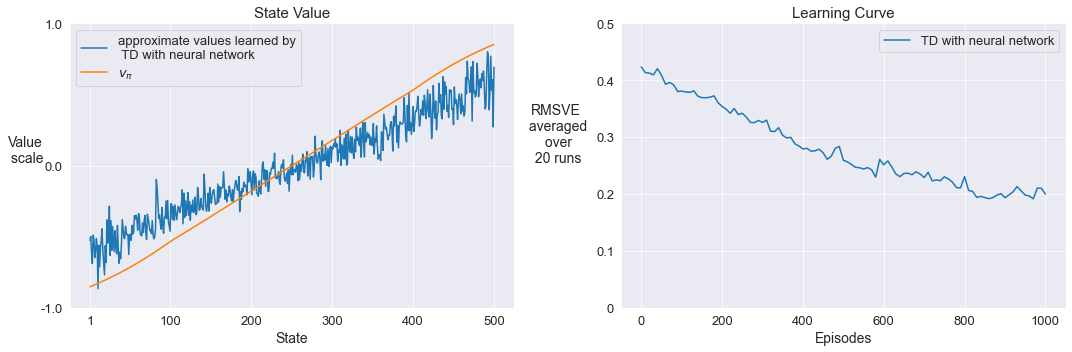

'C:\\Users\\frell\\Documents\\GitHub\\RL\\Course3\\TD-NN\\results.zip'

In [18]:
# ---------------
# Discussion Cell
# ---------------

true_state_val = np.load('data/true_V.npy')    
state_distribution = np.load('data/state_distribution.npy')

def calc_RMSVE(learned_state_val):
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

# Define function to run experiment
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save rmsve at the end of each episode
    agent_rmsve = np.zeros((experiment_parameters["num_runs"], 
                            int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]) + 1))
    
    # save learned state value at the end of each run
    agent_state_val = np.zeros((experiment_parameters["num_runs"], 
                                environment_parameters["num_states"]))

    env_info = {"num_states": environment_parameters["num_states"],
                "start_state": environment_parameters["start_state"],
                "left_terminal_state": environment_parameters["left_terminal_state"],
                "right_terminal_state": environment_parameters["right_terminal_state"]}

    agent_info = {"num_states": environment_parameters["num_states"],
                  "num_hidden_layer": agent_parameters["num_hidden_layer"],
                  "num_hidden_units": agent_parameters["num_hidden_units"],
                  "step_size": agent_parameters["step_size"],
                  "discount_factor": environment_parameters["discount_factor"],
                  "beta_m": agent_parameters["beta_m"],
                  "beta_v": agent_parameters["beta_v"],
                  "epsilon": agent_parameters["epsilon"]
                 }
    
    print('Setting - Neural Network with 100 hidden units')
    os.system('sleep 1')

    # one agent setting
    for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
        env_info["seed"] = run
        agent_info["seed"] = run
        rl_glue.rl_init(agent_info, env_info)
        
        # Compute initial RMSVE before training
        current_V = rl_glue.rl_agent_message("get state value")
        agent_rmsve[run-1, 0] = calc_RMSVE(current_V)
        
        for episode in range(1, experiment_parameters["num_episodes"]+1):
            # run episode
            rl_glue.rl_episode(0) # no step limit

            if episode % experiment_parameters["episode_eval_frequency"] == 0:
                current_V = rl_glue.rl_agent_message("get state value")
                agent_rmsve[run-1, int(episode/experiment_parameters["episode_eval_frequency"])] = calc_RMSVE(current_V)
            elif episode == experiment_parameters["num_episodes"]: # if last episode
                current_V = rl_glue.rl_agent_message("get state value")

        agent_state_val[run-1, :] = current_V

    save_name = "{}".format(rl_glue.agent.name).replace('.','')
    
    if not os.path.exists('results'):
                os.makedirs('results')
    
    # save avg. state value
    np.save("results/V_{}".format(save_name), agent_state_val)

    # save avg. rmsve
    np.savez("results/RMSVE_{}".format(save_name), rmsve = agent_rmsve,
                                                   eval_freq = experiment_parameters["episode_eval_frequency"],
                                                   num_episodes = experiment_parameters["num_episodes"])


# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 20,
    "num_episodes" : 1000,
    "episode_eval_frequency" : 10 # evaluate every 10 episode
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
agent_parameters = {
    "num_hidden_layer": 1,
    "num_hidden_units": 100,
    "step_size": 0.001,
    "beta_m": 0.9,
    "beta_v": 0.999,
    "epsilon": 0.0001,
}

current_env = RandomWalkEnvironment
current_agent = TDAgent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

# plot result
plot_script.plot_result(["td_agent"])

shutil.make_archive('results', 'zip', 'results')

You plotted the learning curve for 1000 episodes. As you can see the RMSVE is still decreasing. Here we provide the pre-computed result for 5000 episodes and 20 runs so that you can see the performance of semi-gradient TD with a neural network after being trained for a long time.

![](nn_5000_episodes.png)


Does semi-gradient TD with a neural network find a good approximation within 5000 episodes? 

As you may remember from the previous assignment, semi-gradient TD with 10-state aggregation converged within 100 episodes. Why is TD with a neural network slower?

Would it be faster if we decrease the number of hidden units? Or what about if we increase the number of hidden units?

## 2-2: Compare Performance of Semi-gradient TD with a Neural Network and Semi-gradient TD with Tile-coding

In this section, we compare the performance of semi-gradient TD with a Neural Network and semi-gradient TD with tile-coding. Tile-coding is a kind of coarse coding that uses multiple overlapping partitions of the state space to produce features. For tile-coding, we used 50 tilings each with 6 tiles. We set the step-size for semi-gradient TD with tile-coding to $\frac{0.1}{\text{# tilings}}$. See the figure below for the comparison between semi-gradient TD with tile-coding and semi-gradient TD with a neural network and Adam algorithm. This result is for 5000 episodes and 20 runs:
![](nn_vs_tc.png)

How are the results?

Semi-gradient TD with tile-coding is much faster than semi-gradient TD with a neural network. Why?

Which method has a lower RMSVE at the end of 5000 episodes?

### Wrapping up! 

You have successfully implemented Course 3 Programming Assignment 2.

You have implemented **semi-gradient TD with a Neural Network and Adam algorithm** in 500-state Random Walk. 

You also compared semi-gradient TD with a neural network and semi-gradient TD with tile-coding. 

From the experiments and lectures, you should be more familiar with some of the strengths and weaknesses of using neural networks as the function approximator for an RL agent. On one hand, neural networks are powerful function approximators capable of representing a wide class of functions. They are also capable of producing features without exclusively relying on hand-crafted mechanisms. On the other hand, compared to a linear function approximator with tile-coding, neural networks can be less sample efficient. When implementing your own Reinforcement Learning agents, you may consider these strengths and weaknesses to choose the proper function approximator for your problems.